In [24]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../src/")
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from process import BertProcessor

raw_docs_dir = "../data/raw_docs/"
labels_dir = "../data/labels/"


def get_doc_paths(docs_dir, lang):
    doc_paths = [os.path.join(docs_dir, lang, doc_name) for doc_name in os.listdir(os.path.join(docs_dir, lang)) if doc_name[-4:] == ".txt"]
    return doc_paths

def get_pickle_paths(pickles_dir, lang):
    pickle_paths = [os.path.join(pickles_dir, lang, pickle_name) for pickle_name in os.listdir(os.path.join(pickles_dir, lang)) if pickle_name[-7:] == ".pickle"]
    return pickle_paths

def read_labels(lang):
    labels_df = pd.read_csv(os.path.join(labels_dir, lang, "canonisation_scores.csv"), sep=";")
    if lang == "eng":
        file_name_mapper = {
            'The Wild Irish Girl': 'Owenson_Sydney_The-Wild-Irish-Girl_1806',
            'Somerville-Ross_The-Real-Charlotte_1894': "Somerville-Ross_Edith-Martin_The-Real-Charlotte_1894",
            'LeFanu_Joseph-Sheridan_Schalken-the-Painter_1851.txt': 'LeFanu_Joseph-Sheridan_Schalken-the-Painter_1851',
        }

        for key, value in file_name_mapper.items():
            labels_df["file_name"][labels_df["file_name"] == key] = value
        
        extra_file_names = [
            "Austen_Jane_Northanger-Abbey_1818",
            "Cleland_John_Fanny-Hill_1748",
            "Defoe_Daniel_Roxana_1724",
            "Fielding_Henry_Amelia_1752",
            "Kingsley_Charles_The-Water-Babies_1863",
            "Le-Queux_William_The-Invasion-of-1910_1906",
            "Surtees_Robert_Jorrocks-Jaunts-and-Jollities_1831"
        ]
        labels = dict(labels_df[~labels_df["file_name"].isin(extra_file_names)][["file_name", "percent"]].values)
    elif lang == "ger":
        file_name_mapper = {
            'Ebner-Eschenbach_Marie-von_Bozena_1876': 'Ebner-Eschenbach_Marie_Bozena_1876',
            'Ebner-Eschenbach_Marie-von_Das-Gemeindekind_1887': 'Ebner-Eschenbach_Marie_Das-Gemeindekind_1887',
            'Ebner-Eschenbach_Marie-von_Der-Kreisphysikus_1883': 'Ebner-Eschenbach_Marie_Der-Kreisphysikus_1883',
            'Ebner-Eschenbach_Marie-von_Der-Muff_1896': 'Ebner-Eschenbach_Marie_Der-Muff_1896',
            'Ebner-Eschenbach_Marie-von_Die-Freiherren-von-Gemperlein_1889': 'Ebner-Eschenbach_Marie_Die-Freiherren-von-Gemperlein_1889',
            'Ebner-Eschenbach_Marie-von_Die-Poesie-des-Unbewussten_1883': 'Ebner-Eschenbach_Marie_Die-Poesie-des-Unbewussten_1883',
            'Ebner-Eschenbach_Marie-von_Die-Resel_1883': 'Ebner-Eschenbach_Marie_Die-Resel_1883',
            'Ebner-Eschenbach_Marie-von_Ein-kleiner-Roman_1887': 'Ebner-Eschenbach_Marie_Ein-kleiner-Roman_1887',
            'Ebner-Eschenbach_Marie-von_Krambabuli_1883': 'Ebner-Eschenbach_Marie_Krambabuli_1883',
            'Ebner-Eschenbach_Marie-von_Lotti-die-Uhrmacherin_1874': 'Ebner-Eschenbach_Marie_Lotti-die-Uhrmacherin_1874',
            'Ebner-Eschenbach_Marie-von_Rittmeister-Brand_1896': 'Ebner-Eschenbach_Marie_Rittmeister-Brand_1896',
            'Ebner-Eschenbach_Marie-von_Unsuehnbar_1890': 'Ebner-Eschenbach_Marie_Unsuehnbar_1890',
            'Hunold_Christian-Friedrich_Adalie_1702': 'Hunold_Christian_Friedrich_Die-liebenswuerdige-Adalie_1681'
        }
        for key, value in file_name_mapper.items():
            labels_df["file_name"][labels_df["file_name"] == key] = value
        labels = dict(labels_df[["file_name", "percent"]].values)
    return labels


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Process Data

In [8]:
lang = "eng"
raw_doc_paths = get_doc_paths(raw_docs_dir, lang)
bp = BertProcessor(lang=lang, pad=False)
bp.process(raw_doc_paths)

# Create Bert Document Vectors

In [4]:
from vectorizer import BertVectorizer

lang = "eng"
bv = BertVectorizer(lang=lang, sentence_to_doc_agg="first")
pickle_paths = get_pickle_paths("../data/processed_bert_512_tokens_not_padded/", lang)
bv.fit(pickle_paths)
df = bv.get_doc_vectors()
labels = read_labels(lang)
df['y'] = df["pickle_path"].apply(lambda x: labels[x.split("/")[-1][:-7]])
df['book_name'] = df['pickle_path'].apply(lambda x: x.split("/")[-1][:-7])

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
INFO:root:Running BertVectorizer...
100%|██████████| 599/599 [19:18<00:00,  1.93s/it]
INFO:root:Finished BertVectorizer.


# Cross Validation

In [33]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

X = df.drop(columns=['y', 'book_name', 'pickle_path']).values
y = df["y"].values.ravel()

all_predictions = []
all_labels = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for index, (train_indices, validation_indices) in enumerate(kf.split(X)):
    train_X = X[train_indices, :]
    train_y = y[train_indices]
    validation_X = X[validation_indices, :]
    validation_y = y[validation_indices]
    pca = PCA(n_components=150)
    train_X = pca.fit_transform(train_X)
    print(pca.explained_variance_ratio_.sum())
    validation_X = pca.transform(validation_X)
    model = SVR(C=20)
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X)
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

0.9503761410211815
Fold: 1, TrainMSE: 259.73554196827985, TrainMAE: 9.69290968866554, ValMSE: 609.8366562460251, ValMAE: 18.188481010232035
0.9501924480788243
Fold: 2, TrainMSE: 263.3140210770812, TrainMAE: 9.614704527440095, ValMSE: 594.0474449824153, ValMAE: 19.167373539217703
0.9503390836829161
Fold: 3, TrainMSE: 279.92449123481595, TrainMAE: 9.91939722117072, ValMSE: 387.72884577378977, ValMAE: 16.281412490923476
0.9502951219972204
Fold: 4, TrainMSE: 246.54291002728692, TrainMAE: 9.324511935958668, ValMSE: 776.3465063186284, ValMAE: 22.555545724485473
0.9502349474448097
Fold: 5, TrainMSE: 271.68593810715754, TrainMAE: 9.507685689300995, ValMSE: 669.4549215429404, ValMAE: 20.6694722178744
0.9500854244386555
Fold: 6, TrainMSE: 265.61338178315657, TrainMAE: 9.952938664797859, ValMSE: 439.85722378488447, ValMAE: 15.466433897533127
0.9499469206519465
Fold: 7, TrainMSE: 263.5730890395128, TrainMAE: 9.585577561840974, ValMSE: 654.5884752222602, ValMAE: 20.108667464993097
0.950780481151404

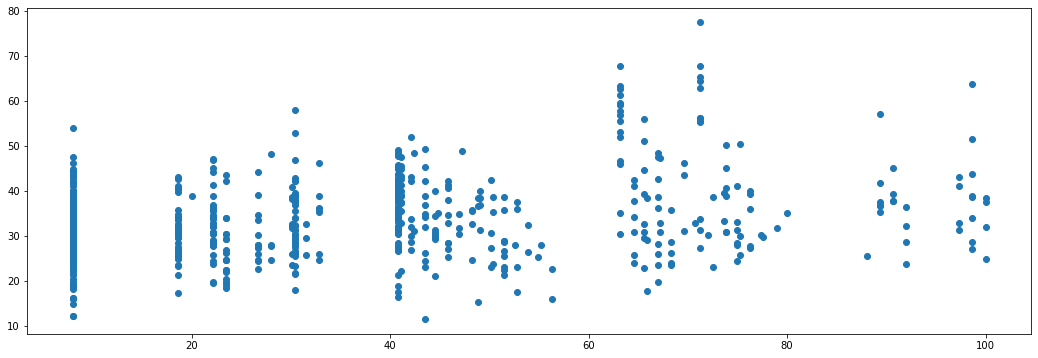

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)
plt.show();